In [12]:
import pandas as pd                                                                        # bring in all the ish you need
import numpy as np
from matplotlib import pyplot
import matplotlib.pylab as plt
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statistics
from sklearn.linear_model import LinearRegression
import pmdarima as pm
from pmdarima.arima.stationarity import ADFTest
from pmdarima.arima import auto_arima
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
import os
from pandas import ExcelWriter
import xlsxwriter
from collections import Counter
import re
import spacy
import random

In [35]:
article_data = pd.read_json(r'C:\DATA\Mckinsey_Articles.json')
#new = pd.read_csv("Mock_Data_Fram.csv")

In [30]:
df = pd.DataFrame(article_data)          # make the CSV a dataframe
text = df['body']               # make the dataframe a series

In [31]:
total = []
for i in range(0,len(text)): 
    total = total + text[i].split()

In [32]:
# Tally occurrences of words in a list
count = Counter()
for word in total:
     count[word] += 1

In [33]:
# Find the ten most common words in the dataset
Counter(total).most_common(10)

[('the', 12994),
 ('to', 9577),
 ('and', 8938),
 ('of', 8189),
 ('in', 5427),
 ('a', 5316),
 ('that', 3853),
 ('for', 3220),
 ('is', 2838),
 ('are', 2435)]

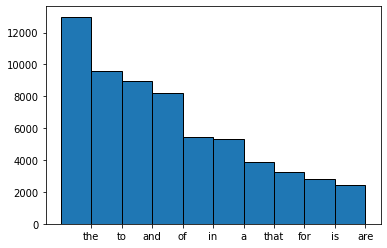

In [34]:
labels, values = zip(*Counter(total).most_common(10))

indexes = np.arange(len(labels))
width = 1

plt.bar(indexes, values, width, ec='black')
plt.xticks(indexes + width * 0.5, labels)
plt.show()

In [15]:
random.shuffle(total)
train = total[:50]
val = total[50:]

In [16]:
#AUTO-ARIMA
M1_stepwise = pm.auto_arima(
    train[0:50],
    start_p=1,
    start_q=1,
    max_p=3,
    max_q=3,
    m=12,
    start_P=0,
    seasonal=False,
    d=1,
    D=1,
    trace=True,
    error_action="ignore",  # don't want to know if an order does not work
    suppress_warnings=True,  # don't want convergence warnings
    stepwise=True,
)

forecast = M1_stepwise.predict(n_periods=len(val[i]))
forecast = pd.DataFrame(forecast, index=val.index, columns=["Prediction"])
M1_stepwise_rms = round(sqrt(mean_squared_error(val[i], forecast)), 3)
ModelComparison = {
    "Model": ["ARIMA"],
    "RMSE": [M1_stepwise_rms],
    "AIC": [M1_stepwise.aic()],
}
MCdf = pd.DataFrame(ModelComparison)

ValueError: could not convert string to float: 'Apparently'

In [19]:
#NAIVE METHOD
dd= np.asarray(train[i])
y_hat = val.copy()
y_hat['naive'] = dd[len(dd)-1]
naive_rms = sqrt(mean_squared_error(val[i], y_hat.naive))  
MCdf = MCdf.append({'Model': 'Naive', 'RMSE':naive_rms, 'AIC': None}, ignore_index=True)

TypeError: len() of unsized object

In [20]:
#SIMPLE AVERAGE
y_hat = val.copy()
y_hat['avg_forecast'] = train[0:50].mode()
simple_avg_rms = sqrt(mean_squared_error(val[i], y_hat.avg_forecast))
MCdf = MCdf.append({'Model': 'Simple Avg', 'RMSE':simple_avg_rms, 'AIC': None}, ignore_index=True)
    


AttributeError: 'list' object has no attribute 'mode'

In [21]:
#EXPONENTIAL SMOOTHING
SES_model = SimpleExpSmoothing(np.asarray(train[i])).fit(smoothing_level=0.8,optimized=True)
#SES_model = SimpleExpSmoothing(np.asarray(train[i])).fit(optimized=True)
y_hat['SES'] = SES_model.forecast(len(val))
SES_model_rms = sqrt(mean_squared_error(val[i], y_hat.SES))
aic=SES_model.aic
MCdf = MCdf.append({'Model': 'Simple Exponential Smoothing', 'RMSE':SES_model_rms, 'AIC':aic}, ignore_index=True)

TypeError: len() of unsized object

In [23]:
#HOLT'S LINEAR TREND METHOD
model_HLTM = Holt(np.asarray(train[i])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat['Holt_linear'] = model_HLTM.forecast(len(val[i]))
model_HLTM_rms = sqrt(mean_squared_error(val[i], y_hat.Holt_linear))
MCdf = MCdf.append({'Model': 'Holts Line', 'RMSE':model_HLTM_rms, 'AIC': model_HLTM.aic}, ignore_index=True)

TypeError: len() of unsized object

In [22]:
#HOLT-WINTERS METHOD
model_hotwinter = ExponentialSmoothing(np.asarray(train[i]) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
y_hat['Holt_Winter'] = model_hotwinter.forecast(len(val[i])) 
model_hotwinter_rms = sqrt(mean_squared_error(val[i], y_hat.Holt_Winter))
MCdf = MCdf.append({'Model': 'Holts-Winters Line', 'RMSE':model_HLTM_rms, 'AIC': model_HLTM.aic}, ignore_index=True)

TypeError: len() of unsized object